# Simulating custom pulses

### Imports and settings

In [1]:
import sys

sys.path.append("../")
import pulse_simulator as ps

In [17]:
import numpy as np
import csv
import functools
import qiskit as qk
import qiskit_dynamics as qk_d
import qiskit.quantum_info as qk_qi
import qiskit.providers.fake_provider as qk_fp
import matplotlib.pyplot as plt
from qiskit.circuit.library import XGate, SXGate, IGate

In [3]:
# configure jax to use 64 bit mode
import jax

jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update("jax_platform_name", "cpu")

# set default backend
qk_d.array.Array.set_default_backend("jax")
qk_d.array.Array.default_backend()

'jax'

In [4]:
backend = qk_fp.FakeManila()
units = 1e9
ns = units
dt = backend.configuration().dt * ns

### Retrieve saved pulses

In [5]:
file_name = "../pico-pulses/saved-pulses-23-12-05/a_single_qubit_gateset_R1e-3.csv"
gates = []

with open(file_name) as file:
    reader = csv.reader(file)
    for row in reader:
        gates.append(np.array([float(x) for x in row]))

Rescale pulses so that their integral remains the same when changing `dt`.

In [6]:
expected = np.trapz(gates[0], dx=0.2)
expected

4.706329489595866

In [7]:
normalization = np.trapz(gates[0], dx=dt) / expected
normalization

1.1111111111111112

In [8]:
normalized_pulse = gates[0] / normalization
np.trapz(normalized_pulse, dx=dt)

4.706329489595865

### Construct a solver

In [9]:
registers = [0]
config_vars = ps.backend_simulation_vars(backend, rabi=True, units=units)

H_rx = functools.partial(
    ps.rx_model,
    registers=registers,
    backend=backend,
    variables=config_vars,
    rotating_frame=False,
)

Hs_control = []
Hs_channels = []
for qubit in range(1):
    Hj_drift, Hjs_control, Hjs_channel = H_rx(qubit)
    Hs_control += Hjs_control
    Hs_channels += Hjs_channel


solver = qk_d.Solver(
    static_hamiltonian=None,
    hamiltonian_operators=Hs_control,
    static_dissipators=None,
    rotating_frame=None,
    rwa_cutoff_freq=None,
    hamiltonian_channels=Hs_channels,
    channel_carrier_freqs={ch: 0.0 for ch in Hs_channels},
    dt=dt,
)

In [10]:
def get_pulse_unitary(pulse_array, duration, solver, expected=None):
    duration = duration * dt
    
    # rescale pulse if needed
    if not expected:
        expected = np.trapz(pulse_array, dx=0.2)
    normalization = np.trapz(pulse_array, dx=dt) / expected
    pulse_array = pulse_array / normalization

    # construct pulse and pulse moment
    pulse = qk.pulse.Waveform(pulse_array, limit_amplitude=False)
    with qk.pulse.build() as pulse_moment:
        channel = qk.pulse.DriveChannel(0)
        qk.pulse.play(pulse, channel)

    U0 = ps.qiskit_identity_operator(1)
    sol = solver.solve(
        t_span=[0.0, duration],
        y0=U0,
        signals=pulse_moment,
        atol=1e-8,
        rtol=1e-8,
        method="jax_odeint",
    )
    
    return sol.y[-1]

With this, we can get the fidelitites of each individual gate.

In [11]:
expected_list = [XGate(), XGate(), SXGate(), SXGate()]
expected_angle = [np.pi / 2, np.pi / 2, np.pi / 4, np.pi / 4]

for i, gate in enumerate(gates):
    print("Output unitary:")
    out = get_pulse_unitary(gate, 50, solver, expected=expected_angle[i])
    print(np.round(out.data, 5))

    print("Expected unitary:")
    expected = qk_qi.Operator(expected_list[i])
    #print(np.round(expected.data, 5))

    print("Fidelity: ", qk_qi.process_fidelity(expected, out, require_cp=False, require_tp=False), "\n")

Output unitary:
[[0.07103+0.j      0.     -0.99747j]
 [0.     -0.99747j 0.07103+0.j     ]]
Expected unitary:
Fidelity:  0.994954582567149 

Output unitary:
[[0.07105+0.j      0.     -0.99747j]
 [0.     -0.99747j 0.07105+0.j     ]]
Expected unitary:
Fidelity:  0.9949518273702074 

Output unitary:
[[0.73252+0.j      0.     -0.68075j]
 [0.     -0.68075j 0.73252+0.j     ]]
Expected unitary:
Fidelity:  0.9986594454760274 

Output unitary:
[[0.73179+0.j      0.     -0.68153j]
 [0.     -0.68153j 0.73179+0.j     ]]
Expected unitary:
Fidelity:  0.9987368727946287 



We can also construct a schedule with all the gates and measure its fidelity.

In [12]:
with qk.pulse.build() as all_pulses_moment:
    channel = qk.pulse.DriveChannel(0)
    for pulse_array, expected in zip(gates, expected_angle):
        normalization = np.trapz(pulse_array, dx=dt) / expected
        pulse_array = pulse_array / normalization
        pulse = qk.pulse.Waveform(pulse_array, limit_amplitude=False)
        qk.pulse.play(pulse, channel)

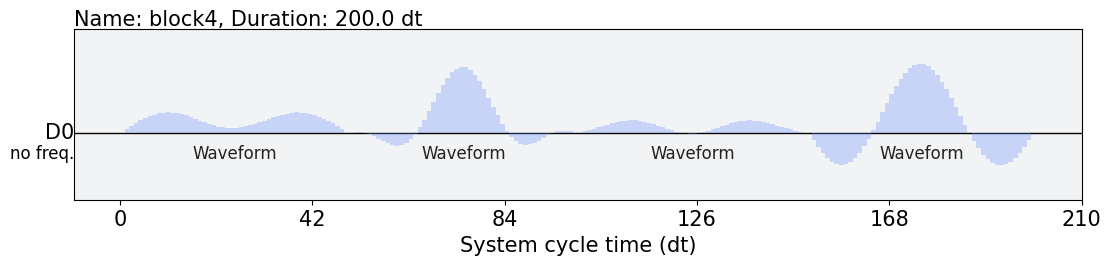

In [13]:
all_pulses_moment.draw()

In [14]:
U0 = ps.qiskit_identity_operator(1)
sol = solver.solve(
    t_span=[0.0, 200],
    y0=U0,
    signals=all_pulses_moment,
    atol=1e-8,
    rtol=1e-8,
    method="jax_odeint",
)
out = sol.y[-1]

In [15]:
out.data

array([[-0.21171394+0.j        ,  0.        +0.97733176j],
       [ 0.        +0.97733176j, -0.21171394+0.j        ]])

In [16]:
qk_qi.process_fidelity(out, qk_qi.Operator(XGate()), require_cp=False, require_tp=False)

0.9551773785153842